# Quantum Stock Picking and Quantum Portfolio Optimization

# Introduction
This assignment will shows how we can use mean-variance optimization to pick stocks for a problem for $n$ assets:

 
 
where we use the following notation:

$x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
$\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
$\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
$q > 0$ controls the risk appetite of the decision maker,
and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.
We assume the following simplifications:

all assets have the same price (normalized to 1),
the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.
The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to the optimal solution. This notebook shows how to use the Variational Quantum Eigensolver (VQE) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.

Note: We are not using CVaR as a portfolio statistic here, rather as a heuristic in our VQE procedure, curious students are encouraged to read the paper above.

# To Students: Complete the following sections labeled todo

In [1]:
! pip install qiskit
! pip install qiskit[visualization]
! On the latest version of MacOsX this may require quotes:
! pip install 'qiskit[visualization]'
! pip install qiskit-finance

/bin/bash: On: command not found


In [2]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas
import pandas as pd

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [3]:
#global random seed used throuhgout
seed = 123

In [4]:
# Generate expected return and covariance matrix from (random) time-series

#Todo pick candidate stocks, 3-8 are recommended, stick to 4 if you're going to submit a real quantum experiment to IBM's cloud:

stocks = ['IBM', 'AAPL','GOOGL','AMZN']

# Here are some quantum themed stocks :) 
# ['IBM','AMD','ACN','NVDA','GOOGL','MSFT','AMZN','MU','BABA']
# Feel free to pick any in this list or beyond
    
num_assets = len(stocks)

#IBM has done us a favour and provided a cute data provider they designed.
data = YahooDataProvider(tickers=stocks,
                 start=pandas.Timestamp('2015'),
                 end=pandas.Timestamp.now())
data.run()

# Here we pull apart the IBM qiskit_finance.data_provider internals to retreive our data and format as a pandas DataFrame
df = pandas.DataFrame({data._tickers[tidx]:data._data[tidx] for tidx in range(len(data._tickers))})

# Provided by IBM
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [5]:
q = 0.50                   #  risk appetite 
budget = num_assets  //2   #  stocks to allocate
penalty = num_assets       #  set parameter to scale the budget penalty term
bounds = None              #  Allocation percent: None: 100%

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000133563431 x_0 - 0.001252470921 x_1 - 0.001107371748 x_2
      - 0.001563827890 x_3 + [ 0.000245750948 x_0^2 + 0.000246876432 x_0*x_1
      + 0.000238229623 x_0*x_2 + 0.000189886000 x_0*x_3 + 0.000333937336 x_1^2
      + 0.000365342275 x_1*x_2 + 0.000386444726 x_1*x_3 + 0.000279092751 x_2^2
      + 0.000406751775 x_2*x_3 + 0.000361394698 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

 ## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [8]:
from qiskit import IBMQ
IBMQ.save_account('4b11829689d57f97ccb3b11bf5539f0bca8b98184ac3b9b2f3ff3d9b613257a73e72e953987ee7bb12e19f9b0abab891cb216a58375c957a12619078d6e29cd7', overwrite=True)

In [9]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
IBMQ.providers()[0].backends()[3]

<IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>

In [11]:
res = IBMQ.providers()[0].backends()[3].jobs()[0].result()
res

Result(backend_name='ibmq_bogota', backend_version='1.6.15', qobj_id='d2b875a0-d986-48cb-8e34-6e96f0db0581', job_id='61a9600dfd94263866c6ee70', success=True, results=[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 301, '0x1': 324, '0x2': 152, '0x3': 303, '0x4': 220, '0x5': 340, '0x6': 148, '0x7': 275, '0x8': 215, '0x9': 361, '0xa': 213, '0xb': 251, '0xc': 230, '0xd': 252, '0xe': 148, '0xf': 267}), header=QobjExperimentHeader(clbit_labels=[['c0', 0], ['c0', 1], ['c0', 2], ['c0', 3]], creg_sizes=[['c0', 4]], global_phase=3.926990816987246, memory_slots=4, metadata={}, n_qubits=5, name='circuit-331', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]))], date=2021-12-03 00:23:12+00:00, status=Successful completion, status=QobjHeader(backend_name='ibmq_bogota', backend_version='1.6.15'), execution_id='2e3439a8-53cf-11ec-a908-b02628eaa3aa', time_taken=7.995517015457153, error=None, client_version={'qiskit

In [12]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
#backend=IBMQ.providers()[0].backends()[3]

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)


# print(result.fval)
print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.0023

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 1]	-0.0021		0.2720
 [1 1 0 0]	-0.0010		0.2034
 [1 0 0 1]	-0.0013		0.1711
 [0 1 0 1]	-0.0023		0.1486
 [1 0 1 0]	-0.0009		0.1263
 [0 1 1 0]	-0.0019		0.0785
 [0 1 1 1]	1.0027		0.0001
 [1 0 0 0]	1.0056		0.0000
 [1 1 1 0]	1.0039		0.0000
 [0 0 0 1]	1.0042		0.0000
 [0 1 0 0]	1.0045		0.0000
 [1 0 1 1]	1.0036		0.0000
 [1 1 1 1]	4.0198		0.0000
 [1 1 0 1]	1.0035		0.0000
 [0 0 1 0]	1.0046		0.0000
 [0 0 0 0]	4.0223		0.0000


In [13]:
selected_stocks = list(np.array(stocks)[result.x.astype('bool')])
print(f"Stocks from our Qunatum Stock Picking algorthm selected: {selected_stocks}")

Stocks from our Qunatum Stock Picking algorthm selected: ['AAPL', 'AMZN']


##  Student todo, complete an equity curve, CAGR and IR comparison for the portfolio of all the stocks you selected for optimization compared to one which your Quantum Stock picker put together
hints:

df[selected_stocks] contains a data frame with your stock pick prices.
df is the full list of stocks you started with.

IR selection: 1.36
IR all: 1.17

CAGR selection: 135.52%
CAGR all: 121.99%


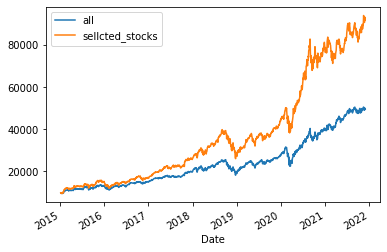

In [14]:
all_df = df
sellcted_df = df[selected_stocks]

all_df_dr = all_df.pct_change().dropna().mean(axis=1)
sellcted_df_dr = sellcted_df.pct_change().dropna().mean(axis=1)


eq_all = 10000*all_df_dr.add(1).cumprod()
eq_selected = 10000*sellcted_df_dr.add(1).cumprod()

eq_all.plot()
eq_selected.plot()
plt.legend(['all','sellcted_stocks'])

IR_sellcted = (sellcted_df_dr.mean() / sellcted_df_dr.std()) * (252) ** 0.5
IR_all = (all_df_dr.mean() / all_df_dr.std()) * (252) ** 0.5

print(f"IR selection: {round(IR_sellcted,2)}")
print(f"IR all: {round(IR_all,2)}\n")

CAGR_sellected = 100*((eq_selected.iloc[-1]/10000)-1)** (252/len(eq_selected)) 
CAGR_all = 100*((eq_all.iloc[-1]/10000)-1)**(252/len(eq_all)) 

#Alternative method to calculate CAGR:
#CAGR_sellected = 100*((eq_selected.iloc[-1]/10000)-1)** (365/(df.index[-1] - df.index[0]).days) 
#CAGR_all = 100*((eq_all.iloc[-1]/10000)-1)**(365/(df.index[-1] - df.index[0]).days) 

print(f"CAGR selection: {round(CAGR_sellected,2)}%")
print(f"CAGR all: {round(CAGR_all,2)}%")

## (Optional) For Advanced Students:
Here we will make some modifications to do portfolio optimization
This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

 
 
where we use the following notation:

$x \in \{-j, +k\}^n$ denotes the vector of binary decision variables, which indicate the relative allocation to assign.
$\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
$\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
$q > 0$ controls the risk appetite of the decision maker,
and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.
We assume the following simplifications:

all assets have the same price (normalized to 1),
the full budget $B$ has to be spent, i.e. one has to allocate exactly $B$ relative amounts of asset.
The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to the optimal solution. This rest of this notebook shows how to use the Variational Quantum Eigensolver (VQE) an optimal solution for a given set of parameters.

In [15]:
q = 0.50                   #  risk appetite 
budget = num_assets        #  Units to allocate
penalty = num_assets //2   #  set parameter to scale the budget penalty term
bounds = [(-1,3)]*num_assets  #  Allocation units, can be negative or positive


portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,bounds=bounds)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000133563431 x_0 - 0.001252470921 x_1 - 0.001107371748 x_2
      - 0.001563827890 x_3 + [ 0.000245750948 x_0^2 + 0.000246876432 x_0*x_1
      + 0.000238229623 x_0*x_2 + 0.000189886000 x_0*x_3 + 0.000333937336 x_1^2
      + 0.000365342275 x_1*x_2 + 0.000386444726 x_1*x_3 + 0.000279092751 x_2^2
      + 0.000406751775 x_2*x_3 + 0.000361394698 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 4

Bounds
 -1 <= x_0 <= 3
 -1 <= x_1 <= 3
 -1 <= x_2 <= 3
 -1 <= x_3 <= 3

Generals
 x_0 x_1 x_2 x_3
End

In [16]:
algorithm_globals.random_seed = seed+1
backend = Aer.get_backend('statevector_simulator')


cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)

/usr/local/lib/python3.7/dist-packages/qiskit_optimization/algorithms/optimization_algorithm.py:141: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


In [17]:
allocations = pandas.DataFrame({f"{stocks[tidx]}":result.x[tidx] for tidx in range(len(stocks))},index=['Allocation'])
allocations

,IBM,AAPL,GOOGL,AMZN
Allocation,-1.0,2.0,2.0,1.0


 ## Student todo, complete an equity curve, CAGR and IR comparison for the a portfolio of all the stocks you selected for optimization compared to one which your Quantum Portfolio Optimzer put together.
hints:

The variable allocations contains a DataFrame with your relative stock allocations.
df is the full list of stocks you started with.

IR selection: 1.39
IR all: 1.17

CAGR selection: 139.74%
CAGR all: 121.99%


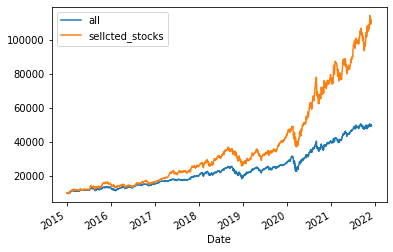

In [18]:
all_df = df
all_df_r = all_df.pct_change().dropna().mean(axis=1)
sellcted_df_r = (df.pct_change().dropna()*allocations.values).mean(axis=1)

intial_capital = 10000



eq_all = intial_capital*all_df_r.add(1).cumprod()
eq_selected = intial_capital*sellcted_df_r.add(1).cumprod()

eq_all.plot()
eq_selected.plot()
plt.legend(['all','sellcted_stocks'])

IR_sellcted = (sellcted_df_r.mean() / sellcted_df_r.std()) * (252) ** 0.5
IR_all = (all_df_r.mean() / all_df_r.std()) * (252) ** 0.5

print(f"IR selection: {round(IR_sellcted,2)}")
print(f"IR all: {round(IR_all,2)}\n")

CAGR_sellected = 100*((eq_selected.iloc[-1]/intial_capital)-1)** (252/len(eq_selected)) 
CAGR_all = 100*((eq_all.iloc[-1]/intial_capital)-1)**(252/len(eq_all)) 

#Alternative method to calculate CAGR:
#CAGR_sellected = 100*((eq_selected.iloc[-1]/10000)-1)** (365/(df.index[-1] - df.index[0]).days) 
#CAGR_all = 100*((eq_all.iloc[-1]/10000)-1)**(365/(df.index[-1] - df.index[0]).days) 

print(f"CAGR selection: {round(CAGR_sellected,2)}%")
print(f"CAGR all: {round(CAGR_all,2)}%")